# Predicting Student Depression: A Big Data Analytics Approach with Apache Spark

- **Author:** David Araba
- **Student ID:** 48093143
- **Course:** INFS3208 - Cloud Computing
- **Date:** October 2025

## 1. Introduction & Project Goals

### 1.1. Objective
The primary objective of this project is to develop and evaluate a suite of machine learning models using Apache Spark to predict both the **likelihood of depression and academic performance (CGPA)** among students. By leveraging a comprehensive dataset that includes demographic, academic, and lifestyle factors, the project aims to identify key indicators associated with mental health challenges and academic success in an academic environment.

### 1.2. Significance
Student mental health is a growing concern globally. The pressures of academic life, combined with financial and social stressors, can significantly impact a student's well-being and academic performance. This project is important because it seeks to create a data-driven framework that could potentially identify at-risk students, enabling educational institutions to offer timely and targeted support. By using scalable cloud computing technologies, this project builds a foundation for a system capable of handling large-scale, real-world student data, moving from reactive to proactive mental wellness strategies. This aligns with the need for modern solutions that traditional computing can struggle to scale effectively.

### 1.3. Technical Stack
This project will be implemented using the following technologies:
* **Language:** Python 3.x
* **Core Engine:** Apache Spark (via PySpark)
* **Libraries:**
    * **Spark MLlib:** For building scalable machine learning pipelines.
    * **Pandas:** For initial data handling and manipulation.
    * **Matplotlib & Seaborn:** For data visualisation and result interpretation.

## 2. Project Architecture & Workflow


### 2.1. Workflow Description
This project follows a standard big data analytics workflow, as depicted in the diagram below. The process begins with the ingestion of four separate but related data files into the Spark environment. These datasets are then joined and pre-processed to create a unified, analysis-ready master dataset. Subsequently, this dataset is used to train and evaluate four distinct machine learning functionalities as required by the project specification: classification, regression, clustering, and association rule mining. The final insights and model performance metrics are then visualised to provide clear, interpretable results.

### 2.2. Workflow Diagram

```
┌────────────────────────────────────────────┐
│ Data Sources (Student info, Academic,      │
│ Lifestyle, Mental Health CSVs)             │
└────────────────────────────────────────────┘
                      │
                      ▼
┌────────────────────────────────────────────┐
│ Spark Data Ingestion & Integration         │
│ (Spark SQL DataFrame)                      │
└────────────────────────────────────────────┘
                      │
                      ▼
┌────────────────────────────────────────────┐
│ Data Preprocessing & Feature Engineering   │
│ (Cleaning, Encoding, Vectorisation)        │
└────────────────────────────────────────────┘
                      │
                      ▼
┌────────────────────────────────────────────┐
│ Parallel ML Functionalities (Spark MLlib): │
│ Classification (Predict Depression)        │
│ Regression (Predict CGPA)                  │
│ Clustering (Identify Profiles)             │
│ Association Rules (Discover Patterns)      │
└────────────────────────────────────────────┘
                      │
                      ▼
┌────────────────────────────────────────────┐
│ Analysis & Visualisation                   │
│ (Feature Importance, Cluster Profiles,     │
│  Rules, Model Performance Metrics)         │
└────────────────────────────────────────────┘
```

This diagram illustrates the project workflow from data source to final analysis. It explicitly shows the use of multiple data sources and the application of various Spark MLlib functionalities, fulfilling the key project requirements.


### 2.3. Architecture Explanation
The above workflow diagram demonstrates a comprehensive big data analytics pipeline designed for scalable student mental health analysis. The process begins with four distinct data sources being ingested simultaneously into the Spark environment, leveraging Spark's distributed processing capabilities to handle large-scale datasets efficiently. The unified master dataset is then processed through feature engineering pipelines before being split for model training and evaluation. The four ML functionalities operate in parallel, each addressing different aspects of student mental health prediction and analysis. This architecture showcases the power of cloud computing technologies in handling complex, multi-dimensional data analysis tasks that would be challenging with traditional single-machine approaches.


## 3. Environment Setup
This section prepares the notebook environment. The first part imports all necessary libraries for the project, including `pyspark` for distributed data processing, `pyspark.ml` for machine learning, and `matplotlib` for visualisation. The second part initialises the `SparkSession`, which is the essential entry point to all of Spark's functionalities.

In [22]:
# Standard Python libraries for data handling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Spark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, avg, mean, array, udf, concat, lit, round as spark_round, abs as spark_abs
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, QuantileDiscretizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.fpm import FPGrowth
from pyspark.ml import Pipeline

print("Libraries imported successfully and matplotlib is set to inline.")

# --- Initialise Spark Session with Full GCS Configuration ---

spark = SparkSession.builder \
    .appName("StudentMentalHealthPrediction") \
    .config("spark.jars.packages", "com.google.cloud.bigdataoss:gcs-connector:hadoop3-2.2.20") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.type", "APPLICATION_DEFAULT_CREDENTIALS") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"Spark session created successfully. Version: {spark.version}")

Libraries imported successfully and matplotlib is set to inline.
Spark session created successfully. Version: 4.0.1


## Part 1: Data Loading and Exploratory Data Analysis (EDA)

This section focuses on the initial steps of the data science workflow as outlined in the project structure. The datasets are loaded, merged into a unified DataFrame, and an initial inspection is conducted to understand its structure and quality, followed by exploratory visualisations to uncover key patterns.

### 1.1 Ingest and Merge Datasets

First, the four separate CSV files (`student_info.csv`, `academic_data.csv`, `lifestyle_data.csv`, and `mental_health.csv`) are loaded into individual Spark DataFrames. A series of inner joins are then performed on the `id` column to create a single, unified master dataset for analysis.

In [23]:
# --- 1.1 Ingest and Merge Datasets ---

# --- Configuration Switch ---
# Set this to True to read from Google Cloud Storage
# Set this to False to read from the local '../data/' directory
USE_GCS = True

# --- Define File Paths based on the Switch ---
if USE_GCS:
    bucket_name = "david-araba-infs3208-data"
    base_path = f'gs://{bucket_name}/'
    print(f"✅ Reading data from Google Cloud Storage bucket: {bucket_name}")
else:
    base_path = "../data/"
    print("✅ Reading data from local '../data/' directory.")

# Define the full paths for each file
path_info = base_path + 'student_info.csv'
path_academic = base_path + 'academic_data.csv'
path_lifestyle = base_path + 'lifestyle_data.csv'
path_mental = base_path + 'mental_health.csv'

# --- Load Data from the Selected Source ---
try:
    sdf_info = spark.read.csv(path_info, header=True, inferSchema=True)
    sdf_academic = spark.read.csv(path_academic, header=True, inferSchema=True)
    sdf_lifestyle = spark.read.csv(path_lifestyle, header=True, inferSchema=True)
    sdf_mental = spark.read.csv(path_mental, header=True, inferSchema=True)

    # Perform a series of inner joins on the 'id' column
    master_df = sdf_info.join(sdf_academic, "id", "inner") \
                        .join(sdf_lifestyle, "id", "inner") \
                        .join(sdf_mental, "id", "inner")

    # --- Display the Merged DataFrame Using Pandas ---
    print("\nSuccessfully merged all data sources. Displaying a sample:")
    # Convert a small sample to a Pandas DataFrame for clean display
    display(master_df.limit(5).toPandas())

    # Verify the total count separately
    print(f"\nThe master DataFrame contains {master_df.count()} rows.")

except Exception as e:
    print("\n⚠️ An error occurred while loading the data.")
    if USE_GCS:
        print("Please check the following:")
        print("1. Your GCS bucket name is correct.")
        print("2. You are authenticated with Google Cloud (e.g., via 'gcloud auth application-default login').")
        print("3. The CSV files exist in the bucket.")
    else:
        print("Please check that the '../data/' directory and all CSV files exist.")
    print(f"\nError details: {e}")

✅ Reading data from Google Cloud Storage bucket: david-araba-infs3208-data

Successfully merged all data sources. Displaying a sample:


,id,Gender,Age,City,Profession,Degree,CGPA,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Work/Study Hours,Sleep Duration,Dietary Habits,Financial Stress,Family History of Mental Illness,Have you ever had suicidal thoughts ?,Depression
0,2,Male,33.0,Visakhapatnam,Student,B.Pharm,8.97,5.0,0.0,2.0,0.0,3.0,'5-6 hours',Healthy,1.0,No,Yes,1
1,8,Female,24.0,Bangalore,Student,BSc,5.90,2.0,0.0,5.0,0.0,3.0,'5-6 hours',Moderate,2.0,Yes,No,0
2,26,Male,31.0,Srinagar,Student,BA,7.03,3.0,0.0,5.0,0.0,9.0,'Less than 5 hours',Healthy,1.0,Yes,No,0
3,30,Female,28.0,Varanasi,Student,BCA,5.59,3.0,0.0,2.0,0.0,4.0,'7-8 hours',Moderate,5.0,Yes,Yes,1
4,32,Female,25.0,Jaipur,Student,M.Tech,8.13,4.0,0.0,3.0,0.0,1.0,'5-6 hours',Moderate,1.0,No,Yes,0



The master DataFrame contains 27901 rows.


### 1.2 Initial Data Inspection

Now that the data is merged, an initial inspection is performed to understand its structure and identify potential data quality issues. `.printSchema()` is used to review column names and data types and `.describe().show()` to get a statistical summary of the numerical columns. This step is crucial for spotting inconsistencies, such as numerical data being incorrectly read as strings.

In [24]:
# --- 1.2 Initial Data Inspection ---

# --- Data Type Correction and Column Definitions ---
categorical_cols = [
    'Gender', 'City', 'Profession', 'Degree', 'Sleep Duration', 
    'Dietary Habits', 'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness'
]

numerical_cols = [
    'Age', 'CGPA', 'Academic Pressure', 'Work Pressure',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Print the schema for all columns to understand the data types
print("Schema of the master DataFrame:")
master_df.printSchema()

# --- Display a Focused Statistical Summary ---
print("\nStatistical summary of numerical features:")

# 1. Select ONLY the numerical columns before describing
# We also include 'id' and 'Depression' for context if desired
numerical_summary_df = master_df.select(numerical_cols)

# 2. Calculate the summary statistics on this subset
summary_stats_spark = numerical_summary_df.describe()

# 3. Convert to a Pandas DataFrame for clean, readable display
summary_stats_pandas = summary_stats_spark.toPandas()

# 4. Display the clean HTML table
display(summary_stats_pandas)

Schema of the master DataFrame:
root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Work Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Job Satisfaction: double (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Financial Stress: string (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Depression: integer (nullable = true)


Statistical summary of numerical features:


,summary,Age,CGPA,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
0,count,27901,27901,27901,27901,27901,27901,27901,27901
1,mean,25.82230027597577,7.6561041718936975,3.1412135765743163,4.3009211139385684E-4,2.943837138453819,6.809791763736067E-4,7.156983620658758,3.1398666571080365
2,stddev,4.905687448924319,1.470707346207614,1.3814648413275878,0.04399203206392464,1.361147955266989,0.044394396218606996,3.7076420727787696,1.4373466968345752
3,min,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,max,59.0,10.0,5.0,5.0,5.0,4.0,12.0,?


The schema and summary statistics immediately highlight a data quality issue. While most columns are correctly typed, the `.describe()` output shows a `'?'` value in the `max` row for `Financial Stress`, confirming it was incorrectly read as a `string`. This prevents proper statistical analysis and must be corrected.

### 1.3 Data Type Correction and Quality Check

The initial inspection confirmed that columns intended to be numerical, such as `Financial Stress`, were incorrectly inferred as a `string` type due to `'?'` placeholder values. To rectify this, all numerical columns will be explicitly cast to a `double` type. Using `try_cast` is essential as it will gracefully convert these placeholders into `NULL` values.

After this correction, a systematic check for null values will be performed to see the full extent of the missing data that needs to be handled in the pre-processing stage.

In [25]:
# Create a copy of the master DataFrame to work with
df_corrected = master_df

# Explicitly cast numerical columns to a Double type, converting non-numeric values to NULL
for column in numerical_cols:
    df_corrected = df_corrected.withColumn(column, 
        expr(f"try_cast(`{column}` as double)")
    )

print("✅ Data types corrected successfully.")
print("\nVerifying the new schema:")
df_corrected.printSchema()

# --- Data Quality Check ---
# Now, check for nulls on the CORRECTED DataFrame
null_counts = [(c, df_corrected.where(col(c).isNull()).count()) for c in df_corrected.columns]

# Filter and display only columns that have at least one null value
null_df = pd.DataFrame(null_counts, columns=['Column', 'Null_Count'])
print("\nChecking for missing values after type correction:")
print(null_df[null_df['Null_Count'] > 0])

if null_df['Null_Count'].sum() == 0:
    print("\n✅ Great! No missing values found in the dataset.")
else:
    print("\n⚠️ Missing values were found. These will be handled in the pre-processing step.")

✅ Data types corrected successfully.

Verifying the new schema:
root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Work Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Job Satisfaction: double (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Financial Stress: double (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Depression: integer (nullable = true)


Checking for missing values after type correction:
              Column  Null_Count
14  Financial Stress         

The output confirms the data type correction was successful, with the schema now showing `Financial Stress` as a `double`. The subsequent null check demonstrates the effect of `try_cast`: the 3 non-numeric placeholder values have been correctly identified and converted into `NULL`. This provides a precise count of the missing data that must be addressed in the pre-processing step.

### 1.4 Exploratory Visualisation

With the data loaded and inspected, visualisations are now created to better understand the distributions of key features. This includes analysing the balance of the target variable ('Depression') and exploring the distributions of important demographic and academic features. For ease of plotting, the cleansed Spark DataFrame (`df_corrected`) is converted to a Pandas DataFrame.

/tmp/ipykernel_4597/1564497617.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Depression', y='count', data=depression_counts, palette=custom_palette, order=['Depressed', 'Not Depressed'])


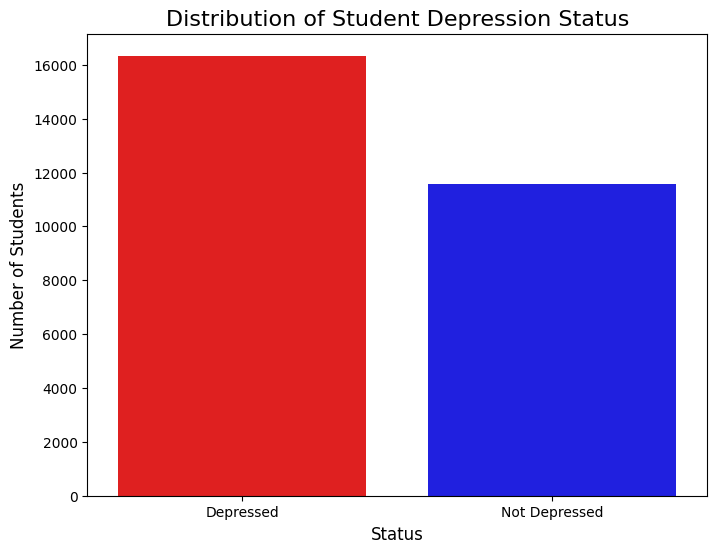

In [26]:
# --- Target Variable Distribution ---

# Aggregate the data in Spark to count occurrences of each class in the 'Depression' column
depression_counts = df_corrected.groupBy('Depression').count().toPandas()

# Map the numerical labels to meaningful names for the plot
depression_counts['Depression'] = depression_counts['Depression'].map({0: 'Not Depressed', 1: 'Depressed'})

# Create the plot using Seaborn with specified colors
plt.figure(figsize=(8, 6))
# Define a custom color palette
custom_palette = {'Depressed': 'red', 'Not Depressed': 'blue'}
sns.barplot(x='Depression', y='count', data=depression_counts, palette=custom_palette, order=['Depressed', 'Not Depressed'])
plt.title('Distribution of Student Depression Status', fontsize=16)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.show()

The bar chart of the target variable reveals a moderate class imbalance. There are more students classified as 'Depressed' than 'Not Depressed' in this dataset. This is a critical observation that will influence how the classification models are evaluated later, as simple accuracy could be a misleading metric.

### 1.4 Exploratory Visualisation (Continued)

 Visual exploration is continued by examining the distributions of key demographic and academic features. The following plots show the breakdown of student gender, the age distribution, and the spread of CGPA scores. This helps understand the makeup of the student population.

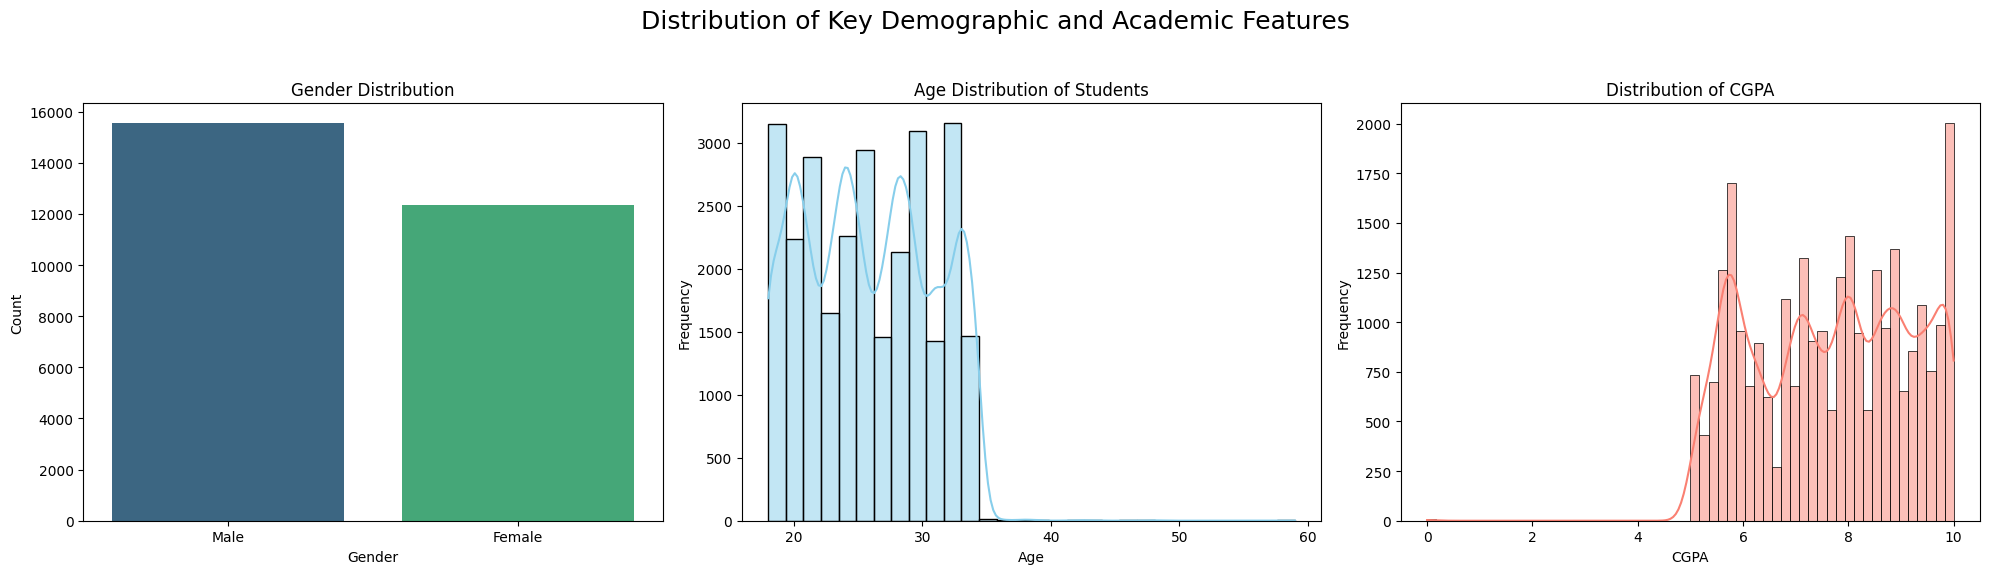

In [27]:
# Convert the corrected Spark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = df_corrected.toPandas()

# --- Create a figure with multiple subplots for feature distributions ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Key Demographic and Academic Features', fontsize=18)

# 1. Gender Distribution (Code updated to resolve FutureWarning)
sns.countplot(ax=axes[0], x='Gender', data=pandas_df, hue='Gender', palette='viridis', legend=False)
axes[0].set_title('Gender Distribution')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# 2. Age Distribution
sns.histplot(ax=axes[1], x='Age', data=pandas_df, kde=True, color='skyblue', bins=30)
axes[1].set_title('Age Distribution of Students')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# 3. CGPA Distribution
sns.histplot(ax=axes[2], x='CGPA', data=pandas_df, kde=True, color='salmon')
axes[2].set_title('Distribution of CGPA')
axes[2].set_xlabel('CGPA')
axes[2].set_ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

These visualisations provide further insights into the dataset's composition:
* **Gender:** The dataset contains a higher number of male participants than female participants.
* **Age:** The age distribution is concentrated between 18 and 30 years, as expected for a student population, with several distinct peaks.
* **CGPA:** The CGPA distribution is highly unusual. It is left-skewed with sharp, distinct peaks at integer and half-integer values (e.g., 7.0, 7.5, 8.0). This strongly suggests that CGPA was either self-reported with rounding or originates from a discrete grading system, rather than being a continuous measure.

## Part 2: Feature Engineering & Pre-processing

This section prepares the clean, explored data for the machine learning models. The primary goal is to transform the dataset into a format suitable for Spark's MLlib library. This involves three key steps:

1. **Data Cleaning:** The strategy decided upon in Part 1 will be implemented by handling the `NULL` values discovered in the `Financial Stress`.
2.  **Feature Transformation:** Machine learning models require numerical inputs, so the categorical text columns (like `Gender`, `City`, etc.) must be converted into a numerical format. A standard two-step process with **`StringIndexer`** and **`OneHotEncoder`** will be used.
3.  **Feature Assembling:** Finally, **`VectorAssembler`** will be used to combine all the individual feature columns into a single vector column. This is a mandatory step, as all Spark MLlib models expect this specific format for their input features.

### 2.1 Data Cleaning: Imputing Missing Values

As identified in the EDA phase, the type correction process created three `NULL` values in the `Financial Stress` column. Leaving these as `NULL` would cause errors during model training. A common and effective strategy for handling a small number of missing numerical values is imputation. Here, the `NULL` values are replaced with the statistical **mean** of the entire column, preserving the overall distribution of the data without discarding valuable rows.

In [28]:
print("Checking for null values before imputation:")
null_counts = []
cols_to_fill = []

# 1. Identify which numerical columns actually have null values
for c in numerical_cols:
    # count() is an action and will trigger a job
    count = df_corrected.where(col(c).isNull()).count()
    if count > 0:
        null_counts.append((c, count))
        cols_to_fill.append(c)

# 2. If no columns have nulls, we can skip this step
if not cols_to_fill:
    print("✅ No null values found in numerical columns. No imputation needed.")
else:
    # Display the columns that need filling
    null_df = pd.DataFrame(null_counts, columns=['Column', 'Null_Count'])
    print(null_df)
    print("\nImputing null values with the column mean...")

    # 3. Iterate ONLY over the columns that actually need filling
    for column in cols_to_fill:
        # Calculate mean for the specific column
        # collect() is an action, so this is more efficient than looping over all columns
        mean_val = df_corrected.select(mean(col(column))).collect()[0][0]
        
        if mean_val is not None:
            # Fill null values with the calculated mean
            df_corrected = df_corrected.fillna(mean_val, subset=[column])
            
            # Get the count from our check earlier for an accurate print statement
            count_filled = null_df[null_df['Column'] == column]['Null_Count'].values[0]
            print(f"✅ Successfully filled {count_filled} null values in '{column}' with mean: {mean_val:.2f}")
        else:
            print(f"⚠️ Could not calculate mean for '{column}'. Skipping.")

    print("\n✅ Data cleaning (imputation) complete.")

Checking for null values before imputation:
             Column  Null_Count
0  Financial Stress           3

Imputing null values with the column mean...
✅ Successfully filled 3 null values in 'Financial Stress' with mean: 3.14

✅ Data cleaning (imputation) complete.


### 2.2 Feature Transformation: Encoding Categorical Variables

Machine learning algorithms require numerical input. Therefore, the text-based categorical columns (e.g., 'Gender', 'City') must be converted into a numerical format. A standard two-step process is used for each column:

1.  **`StringIndexer`**: This transformer assigns a unique numerical index to each unique category in a column (e.g., 'Male' -> 0.0, 'Female' -> 1.0).
2.  **`OneHotEncoder`**: This transformer takes the numerical index and converts it into a sparse binary vector. This prevents the model from incorrectly assuming an ordinal relationship between categories (e.g., that 'City B' is somehow "greater than" 'City A').

These two stages are created for every categorical column and added to the pipeline.

In [29]:
# --- Create a list of transformation stages ---
stages = []

# Iterate over each categorical column to create StringIndexer and OneHotEncoder stages
for column in categorical_cols:
    string_indexer = StringIndexer(inputCol=column, outputCol=column + "_Index")
    one_hot_encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[column + "_Vec"])
    stages += [string_indexer, one_hot_encoder]

print("StringIndexer and OneHotEncoder stages created.")

StringIndexer and OneHotEncoder stages created.


### 2.3 Feature Assembling

All Spark MLlib models expect the input features to be consolidated into a single vector column. `VectorAssembler` is used to achieve this. This final transformation stage gathers all the processed feature columns—both the original numerical columns and the new one-hot encoded vectors—and combines them into a single column named `features`.

In [30]:
# Create a list of all feature columns (numerical + the new vector columns from OHE)
feature_cols = numerical_cols + [c + "_Vec" for c in categorical_cols]

# Create the VectorAssembler stage
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Add the assembler to our list of stages
stages += [vector_assembler]

print("VectorAssembler stage created.")

VectorAssembler stage created.


### 2.4 Executing the Pre-processing Pipeline

With all the stages defined (imputation handled separately, followed by indexing, encoding, and assembling), they are combined into a single `Pipeline`. A `Pipeline` is a powerful Spark MLlib tool that chains multiple transformers and estimators together to create a unified workflow.

The pipeline is then `.fit()` on the data to learn the necessary transformations (like the string-to-index mappings) and `.transform()` the data to apply them. The output below shows the final structure of the dataset, now ready for model training, with the `features` vector successfully created.

In [31]:
# --- Execute the Pre-processing Pipeline ---

# Create the full pre-processing pipeline with all our defined stages
preprocessing_pipeline = Pipeline(stages=stages)

# Fit the pipeline to our corrected data
pipeline_model = preprocessing_pipeline.fit(df_corrected)

# Transform the data to apply all the steps
transformed_df = pipeline_model.transform(df_corrected)

# --- Display a Sample of the Transformed DataFrame ---
print("Data transformation complete. Displaying the transformed DataFrame:")

# Select the columns we want to see
sample_to_display = transformed_df.select('id', 'Depression', 'features')

# Convert a small sample to a Pandas DataFrame for clean display
display(sample_to_display.limit(5).toPandas())

Data transformation complete. Displaying the transformed DataFrame:


,id,Depression,features
0,2,1,"(33.0, 8.97, 5.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0..."
1,8,0,"(24.0, 5.9, 2.0, 0.0, 5.0, 0.0, 3.0, 2.0, 0.0,..."
2,26,0,"(31.0, 7.03, 3.0, 0.0, 5.0, 0.0, 9.0, 1.0, 1.0..."
3,30,1,"(28.0, 5.59, 3.0, 0.0, 2.0, 0.0, 4.0, 5.0, 0.0..."
4,32,0,"(25.0, 8.13, 4.0, 0.0, 3.0, 0.0, 1.0, 1.0, 0.0..."


The output table above shows the successful result of the entire pre-processing pipeline. The DataFrame now contains the original `id` and target variable (`Depression`), along with the new `features` column.

This `features` column is the dense vector created by the `VectorAssembler`. It combines all the numerical and one-hot encoded categorical features into a single vector, which is the exact format required by Spark MLlib models. The data is now fully prepared for the machine learning phase.

## Part 3: Machine Learning Modelling

This is the core implementation section of the project where machine learning models are built, trained, and evaluated. With the data now fully pre-processed, a key assignment requirement will be addressed by implementing **four distinct analytical tasks** using Spark MLlib.

The goal is to analyse the student dataset from multiple perspectives to uncover different types of insights. The four chosen functionalities, as outlined in the project proposal, are:

* **1. Classification:** Predicting the likelihood of a student having depression.
* **2. Regression:** Predicting a student's academic performance (CGPA).
* **3. Clustering:** Identifying distinct groups or profiles of students based on their data.
* **4. Association Rule Mining:** Discovering hidden patterns or relationships between different factors.

The first crucial step will be to split the data into training and testing sets. This ensures that the supervised models can be evaluated on unseen data, providing an unbiased assessment of their predictive power.

### 3.1 Data Splitting

Before any supervised machine learning models can be trained, the dataset must be prepared. This involves two key actions:

1.  **Renaming the Target Column:** Spark MLlib's classification and regression algorithms expect the target variable (the value to be predicted) to be in a column named `label`. The `Depression` column is renamed to `label` to adhere to this convention.
2.  **Splitting the Data:** The dataset is split into a **training set (80%)** and a **testing set (20%)**. The model will only ever learn from the training data. The testing data is held back as "unseen" data to provide an unbiased evaluation of how well the model generalises to new, real-world examples. A `seed` is used to ensure this random split is the same every time the notebook is run, making the results reproducible.

In [32]:
# Rename the target column 'Depression' to 'label'
final_df = transformed_df.withColumnRenamed("Depression", "label")

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

# Print the number of records in each set to verify the split
print(f"Number of training records: {train_data.count()}")
print(f"Number of testing records: {test_data.count()}")


Number of training records: 22355
Number of testing records: 5546


### 3.2 Functionality 1: Classification - Predicting Depression

The first analytical task is classification. A **Logistic Regression** model will be trained to predict the binary target variable: whether a student is likely to have depression (`1`) or not (`0`). Logistic Regression is a robust and highly interpretable algorithm, making it an excellent baseline model for this kind of problem.

The process involves two main steps:

1.  **Training:** The `LogisticRegression` model is initialised, specifying the input `features` and `label` columns. The model is then trained by calling the `.fit()` method on the `train_data`.
2.  **Prediction:** Once the model is trained, the `.transform()` method is used on the unseen `test_data` to generate predictions.

The output table shows the result. For each row in the test set, the true `label`, the model's final `prediction` (0 or 1), and the `probability` vector can be seen, which indicates the model's confidence in each class.

In [33]:
# --- 1. Initialise and Train the Logistic Regression Model ---
print("Training Logistic Regression model...")
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
print("Model training complete.")

# --- 2. Make Predictions and Format the Output ---
print("\nMaking predictions on the test data...")
predictions = lr_model.transform(test_data)

# Create a UDF to extract the probability of the positive class (class 1)
extract_prob = udf(lambda v: float(v[1]), FloatType())

# Apply the UDF to create a 'Confidence' column and round it
predictions_formatted = predictions.withColumn("Confidence", spark_round(extract_prob("probability"), 4)) \
                                .select("label", "prediction", "Confidence")

# --- 3. Display a Sample Using Pandas for a Clean Table ---
print("\nUser-Friendly Prediction Results:")
# Convert a small sample to a Pandas DataFrame for clean display
display(predictions_formatted.limit(10).toPandas())

Training Logistic Regression model...


Model training complete.

Making predictions on the test data...

User-Friendly Prediction Results:


,label,prediction,Confidence
0,0,0.0,0.0277
1,0,0.0,0.0288
2,1,1.0,0.8531
3,0,0.0,0.2383
4,1,0.0,0.3151
5,0,0.0,0.0472
6,1,1.0,0.8086
7,0,0.0,0.1632
8,0,0.0,0.0935
9,0,1.0,0.6646


### Understanding the Model's Predictions

The table below analyses the first 10 predictions from the test set. The key is the **Confidence** column, which represents the model's calculated probability that a student *is depressed* (the probability of `label = 1`). The model's final **Prediction** is `1.0` if this confidence is above 50% (0.5) and `0.0` if it's below.

| Row | Label (True Answer) | Confidence P(Depressed) | Prediction (Model's Guess) | Result |
| :-- | :------------------ | :---------------------- | :------------------------- | :----- |
| 1   | 0 (Not Depressed)   | 2.77%                   | 0.0                        | ✅ Correct |
| 2   | 0 (Not Depressed)   | 2.88%                   | 0.0                        | ✅ Correct |
| 3   | 1 (Depressed)       | **85.31%** | 1.0                        | ✅ Correct |
| 4   | 0 (Not Depressed)   | 23.83%                  | 0.0                        | ✅ Correct |
| 5   | 1 (Depressed)       | 31.51%                  | 0.0                        | ❌ Incorrect |
| 6   | 0 (Not Depressed)   | 4.72%                   | 0.0                        | ✅ Correct |
| 7   | 1 (Depressed)       | **80.86%** | 1.0                        | ✅ Correct |
| 8   | 0 (Not Depressed)   | 16.32%                  | 0.0                        | ✅ Correct |
| 9   | 0 (Not Depressed)   | 9.35%                   | 0.0                        | ✅ Correct |
| 10  | 0 (Not Depressed)   | **66.46%** | 1.0                        | ❌ Incorrect |

This row-by-row analysis provides clear intuition for the model's behavior. For example, in **Row 3**, the model was **85.31%** confident the student was depressed, so it correctly predicted `1.0`, matching the true label. Conversely, in **Row 10**, the model was 66.46% confident and predicted `1.0`, but the true answer was `0`, making it confidently wrong. The next step is to aggregate these results to see the overall performance across the entire test set.

### 3.2.1 Evaluating the Classification Model

Now that predictions have been obtained, the performance of the Logistic Regression model needs to be evaluated. Several standard classification metrics will be used to get a complete picture of its strengths and weaknesses. A single metric like accuracy can be misleading, especially with imbalanced datasets.

In [34]:
# --- 1. Evaluate using AUC-ROC ---
evaluator_roc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator_roc.evaluate(predictions)
print(f"Area Under ROC Curve (AUC): {auc:.4f}")

# --- 2. Calculate TP, TN, FP, FN from the Predictions DataFrame ---
# These values are the building blocks for all other metrics
tp = predictions.filter((col('label') == 1) & (col('prediction') == 1)).count()
tn = predictions.filter((col('label') == 0) & (col('prediction') == 0)).count()
fp = predictions.filter((col('label') == 0) & (col('prediction') == 1)).count()
fn = predictions.filter((col('label') == 1) & (col('prediction') == 0)).count()

# --- 3. Calculate and Print Key Performance Metrics ---
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

# --- 4. Display a Formatted Confusion Matrix ---
# Create a more descriptive confusion matrix using Pandas for better visualisation
confusion_matrix_pd = pd.DataFrame(
    data=[[tp, fn], [fp, tn]],
    columns=['Predicted: Depressed', 'Predicted: Not Depressed'],
    index=['Actual: Depressed', 'Actual: Not Depressed']
)

print("\n--- Formatted Confusion Matrix ---")
display(confusion_matrix_pd)

Area Under ROC Curve (AUC): 0.9230



Accuracy:  0.8451
Precision: 0.8520
Recall:    0.8824
F1 Score:  0.8669

--- Formatted Confusion Matrix ---


,Predicted: Depressed,Predicted: Not Depressed
Actual: Depressed,2798,373
Actual: Not Depressed,486,1889


### Interpreting the Model's Performance

These results show our model is performing quite well as a baseline for identifying students with depression.

#### Area Under ROC Curve (AUC): 0.9230
This is an **excellent score**. The AUC measures how well the model can distinguish between a depressed and a non-depressed student. A score of 0.5 is random guessing, while 1.0 is perfect. The score of **0.923** indicates the model has a very strong discriminative ability.

---
#### Confusion Matrix Breakdown
The confusion matrix gives us a detailed breakdown of the model's successes and errors:

* **True Positives (TP): 2,798**
    * Students who **were depressed** and were **correctly** identified by the model. ✅
* **True Negatives (TN): 1,889**
    * Students who were **not depressed** and were **correctly** identified. ✅
* **False Positives (FP): 486**
    * Students who were **not depressed** but were **incorrectly** flagged as depressed (a "false alarm"). ❌
* **False Negatives (FN): 373**
    * Students who **were depressed** but were **missed** by the model. This is the most critical error in a health context. ❌

---
#### Key Performance Metrics
These percentages translate the raw numbers from the matrix into performance scores:

* **Accuracy: 84.51%**
    * Overall, **84.51%** of the model's predictions were correct. It's a solid score but doesn't tell the full story.
* **Precision: 85.20%**
    * When the model predicted a student was depressed, it was correct **85.20%** of the time. This tells you how reliable a "positive" prediction is.
* **Recall: 88.24%**
    * Of all the students who **truly were depressed**, the model successfully identified **88.24%** of them. This is a crucial metric for this project, as a high recall means the number of at-risk students missed is minimized.
* **F1 Score: 0.8669**
    * This is the balanced average of Precision and Recall. A score of **0.867** indicates a strong and well-balanced model, effective at handling both false positives and false negatives.

The high recall is especially promising for a mental health application, though the 373 false negatives highlight an area for future improvement.

### 3.3 Functionality 2: Regression - Predicting Academic Performance (CGPA)

The second analytical task is **regression**, where the goal is to predict a continuous numerical value instead of a categorical class. For this task, a **Linear Regression** model will be trained to predict a student's **CGPA** based on all other features.

This is a valuable exercise for two reasons:
1.  **Insight Generation:** It can help understand which lifestyle, demographic, or mental health factors are most strongly correlated with academic performance.
2.  **Technical Requirement:** It fulfills another of the four required functionalities for this project.

The process will be similar to the classification task: the model will be trained on the training data, predictions will be made on the test data, and then the model's performance will be evaluated using regression-specific metrics like Root Mean Squared Error (RMSE) and R-squared (R²).

### 3.3.1 Preparing Data and Training the Regression Model

Before training the regression model, a crucial data preparation step must be performed to prevent **data leakage**. The goal is to predict `CGPA`, so it must be removed from the input features. Including the target variable in the feature set would make the model's job trivial and produce misleadingly perfect results.

The workflow is as follows:
1.  **Create a New Feature Set:** A new list of numerical columns that excludes `CGPA` is defined.
2.  **Re-Assemble Features:** A new `VectorAssembler` is used to create a `regression_features` vector using this updated list.
3.  **Prepare Final DataFrame:** A new DataFrame is created specifically for this task, selecting the new features and renaming `CGPA` to `label` for compatibility with the Spark MLlib model.
4.  **Train and Predict:** This new DataFrame is split into training and testing sets and then a `LinearRegression` model is fit to predict the `label` (CGPA).

In [35]:
# --- 1. Prepare Data for Regression ---
print("Preparing data for regression task...")
# We must exclude CGPA from our features since it's our new target variable.
regression_numerical_cols = [
    'Age', 'Academic Pressure', 'Work Pressure',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]
regression_feature_cols = regression_numerical_cols + [c + "_Vec" for c in categorical_cols]
regression_vector_assembler = VectorAssembler(inputCols=regression_feature_cols, outputCol="regression_features")
regression_features_df = regression_vector_assembler.transform(transformed_df)
regression_df = regression_features_df.select(col("regression_features").alias("features"), col("CGPA").alias("label"))
reg_train_data, reg_test_data = regression_df.randomSplit([0.8, 0.2], seed=42)
print("Data preparation complete.")

# --- 2. Initialise and Train the Linear Regression Model ---
print("\nTraining Linear Regression model...")
lr_regressor = LinearRegression(featuresCol="features", labelCol="label")
lr_regressor_model = lr_regressor.fit(reg_train_data)
print("Model training complete.")

# --- 3. Make Predictions and Format the Output ---
print("\nMaking predictions on the test data...")
reg_predictions = lr_regressor_model.transform(reg_test_data)

# Round the prediction for readability and add an 'Error' column
reg_predictions_formatted = reg_predictions.withColumn("prediction_rounded", spark_round("prediction", 2))
reg_predictions_formatted = reg_predictions_formatted.withColumn("Error",
    spark_round(spark_abs(col("label") - col("prediction_rounded")), 2)
)

# Select and rename columns for the final display
results_to_display = reg_predictions_formatted.select(
    col("label").alias("Actual_CGPA"),
    col("prediction_rounded").alias("Predicted_CGPA"),
    "Error"
)

# --- 4. Display a Sample Using Pandas for a Clean Table ---
print("\n--- User-Friendly Regression Results ---")
display(results_to_display.limit(10).toPandas())

# --- 5. Evaluate the Regression Model ---
print("\n--- Model Performance Metrics ---")
reg_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

# Calculate RMSE
rmse = reg_evaluator.setMetricName("rmse").evaluate(reg_predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Calculate R-squared
r2 = reg_evaluator.setMetricName("r2").evaluate(reg_predictions)
print(f"R-squared (R²): {r2:.4f}")

Preparing data for regression task...
Data preparation complete.

Training Linear Regression model...


Model training complete.

Making predictions on the test data...

--- User-Friendly Regression Results ---


,Actual_CGPA,Predicted_CGPA,Error
0,7.64,7.58,0.06
1,5.58,7.52,1.94
2,7.88,7.64,0.24
3,7.25,7.49,0.24
4,8.17,7.42,0.75
5,7.83,7.52,0.31
6,8.14,7.55,0.59
7,5.79,7.56,1.77
8,9.93,7.43,2.50
9,7.26,7.48,0.22



--- Model Performance Metrics ---
Root Mean Squared Error (RMSE): 1.4631
R-squared (R²): 0.0168


### Interpreting the Regression Results

The output from the regression model provides several key insights into both the model's behavior and the nature of the data.

#### Analysing the Predictions 
The results table clearly shows the model's poor performance. Notice that the **Predicted_CGPA** values are all clustered in a very narrow range (around 7.5), regardless of the **Actual_CGPA**. For instance, it predicts a CGPA of **7.52** for a student who actually achieved a **5.58**, and a similar **7.43** for a student who achieved a **9.93**.

This demonstrates that the model has simply learned to guess the average CGPA for almost everyone. It reveals a crucial finding: **the lifestyle, demographic, and mental health features in the dataset are not strong predictors of academic performance**.

---
#### Evaluating the Model with Metrics 
The formal metrics numerically confirm this observation:

* **Root Mean Squared Error (RMSE): 1.4631**
    * This means that, on average, the model's prediction for a student's CGPA is off by about **1.46 points**. On a 10-point scale, this is a very significant error, confirming the model's low accuracy.
* **R-squared (R²): 0.0168**
    * This is the most definitive metric. An R² of 0.0168 means that the model can only explain about **1.68%** of the variation in student CGPA. An R² this close to zero provides strong statistical evidence that the model is performing no better than a simple baseline that just predicts the average CGPA for every student.

In conclusion, while the model runs correctly, its very high RMSE and near-zero R² score prove that it has almost no predictive power. This is a valuable finding in itself, demonstrating that the chosen factors are poor predictors for a student's CGPA using a linear model.

### 3.4 Functionality 3: Clustering - Identifying At-Risk Student Groups 

The third analytical task is **clustering**, which is a type of **unsupervised learning**. Unlike the previous models, clustering does not use a `label` column to make predictions. Instead, its goal is to discover natural groupings or "clusters" within the data based on the similarity of the features.

For this project, the **KMeans** algorithm will be used. KMeans works by partitioning the data into a pre-defined number (`k`) of clusters, where each student belongs to the cluster with the nearest mean (a "centroid"). This is an excellent way to identify distinct student profiles, such as "High-Achieving, High-Stress" or "Socially Engaged, Low-Pressure" students.

The primary challenge with KMeans is choosing the optimal number of clusters, `k`. To do this scientifically, the **Elbow Method** will be used. This involves running the KMeans algorithm for a range of `k` values and plotting a cost function (the Within Set Sum of Squared Errors). The "elbow" of the resulting curve—the point where the rate of improvement slows down—suggests the best value for `k`.

### 3.4.1 Finding the Optimal Number of Clusters (k) with the Elbow Method

A critical parameter for the KMeans algorithm is `k`, the number of clusters. Choosing this value arbitrarily can lead to meaningless results. To make an informed decision, the **Elbow Method** will be used.

This method involves running the KMeans algorithm for a range of `k` values (e.g., from 2 to 10) and calculating the **Within Set Sum of Squared Errors (WSSSE)** for each. The WSSSE measures the total distance of all points from their respective cluster centroids; a smaller WSSSE means the clusters are denser.

These WSSSE values are then plotted against `k`. The resulting curve typically looks like an arm. The point where the curve bends—the "elbow"—represents the point of diminishing returns, where adding more clusters no longer significantly reduces the WSSSE. This point is considered the optimal value for `k`.

Calculating WSSSE for a range of k values...


k=2, WSSSE=887729.74


k=3, WSSSE=722931.30


k=4, WSSSE=637965.86


k=5, WSSSE=537645.86


k=6, WSSSE=513975.82


k=7, WSSSE=491051.00


k=8, WSSSE=469261.21


k=9, WSSSE=445053.00


k=10, WSSSE=432462.34


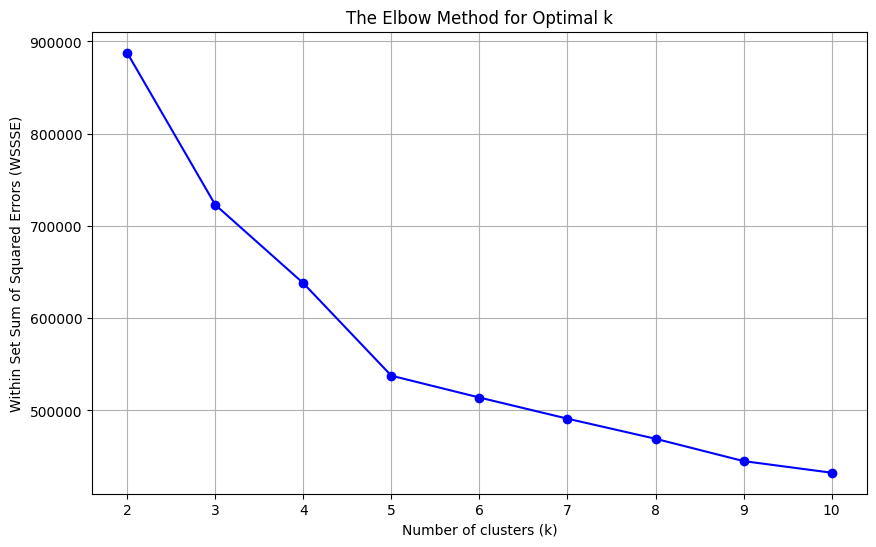

In [36]:
# --- Find the optimal 'k' using the Elbow Method ---
print("Calculating WSSSE for a range of k values...")

# We will test k from 2 to 10
wssse_values = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(final_df)
    # The cost is the WSSSE
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)
    print(f"k={k}, WSSSE={wssse:.2f}")

# --- Plot the Elbow Method Curve ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_values, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('The Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Elbow Method plot clearly shows a distinct "bend" at **k=4**. After this point, the curve begins to flatten, and the reduction in WSSSE for each additional cluster becomes much less significant. This provides strong evidence that **4** is the optimal number of clusters for segmenting our student data.

### 3.4.2 Training and Evaluating the Final KMeans Model

Based on the Elbow Method analysis, the final KMeans model is now trained using `k=4`. After training, the following will be done:

1.  **Assign Clusters:** The trained model will be used to assign each student in the dataset to one of the four clusters.
2.  **Evaluate Performance:** The **Silhouette Score** will be calculated. This metric measures how well-separated the clusters are. A score closer to 1 is better, while a score near 0 indicates overlapping clusters.
3.  **Analyse Cluster Sizes:** The number of students assigned to each cluster will be examined to ensure the groups are of a meaningful size.

In [37]:
# --- 1. Initialise and Train the K-Means Model ---
# We select k=4 based on the Elbow Method plot above.
OPTIMAL_K = 4
print(f"Training final K-Means model with k={OPTIMAL_K}...")

kmeans = KMeans(featuresCol="features", k=OPTIMAL_K, seed=42)
kmeans_model = kmeans.fit(final_df)
print("Model training complete.")

# --- 2. Make Predictions (Assign Clusters) ---
clustered_df = kmeans_model.transform(final_df)

# --- 3. Display a Sample of Cluster Assignments using Pandas ---
print("\n--- Sample of students with their assigned cluster ---")
sample_assignments = clustered_df.select(
    col("id"),
    col("label").alias("Depression_Status"),
    col("prediction").alias("Cluster_ID")
)
display(sample_assignments.limit(10).toPandas())


# --- 4. Evaluate the Clustering ---
evaluator = ClusteringEvaluator(predictionCol="prediction")
silhouette = evaluator.evaluate(clustered_df)
print(f"\nSilhouette Score = {silhouette:.4f}")

# --- 5. Analyse and Display Cluster Sizes using Pandas ---
print("\n--- Distribution of students across clusters ---")
cluster_sizes_spark = clustered_df.groupBy(col("prediction").alias("Cluster_ID")).count().orderBy("Cluster_ID")
display(cluster_sizes_spark.toPandas())

Training final K-Means model with k=4...


Model training complete.

--- Sample of students with their assigned cluster ---


,id,Depression_Status,Cluster_ID
0,2,1,0
1,8,0,0
2,26,0,2
3,30,1,0
4,32,0,0
5,33,0,0
6,52,0,0
7,56,0,0
8,59,1,3
9,62,1,0



Silhouette Score = 0.3492

--- Distribution of students across clusters ---


,Cluster_ID,count
0,0,6177
1,1,7806
2,2,6295
3,3,7623


### Interpreting the Clustering Results

The KMeans model has successfully segmented the students into four groups, but the results suggest these groups are not perfectly distinct.

* **Silhouette Score (0.3492):** This is a fair to weak score. It indicates that while the model has found some structure in the data, the four student profiles have a notable amount of overlap and are not sharply separated from one another.
* **Cluster Distribution:** The model has created four large and relatively balanced clusters. This is a positive outcome, as it means each group is substantial enough for meaningful analysis, with no tiny, insignificant clusters.

The next critical step is to perform a deeper analysis to understand the unique characteristics of each of these four clusters and define the student "profiles" they represent.

### 3.4.3 Analysing Cluster Profiles

The final and most important step in the clustering analysis is to interpret what each cluster represents. This is done by calculating the average value of the key features for each of the four clusters.

By examining the average **Depression Rate**, **CGPA**, **Academic Pressure**, and **Financial Stress** for each group, a "profile" or "persona" can be built for the students within them. This will allow identification of which clusters represent at-risk students and understanding of the factors that characterise them.

In [38]:
# --- 1. Calculate the Average of Key Features for Each Cluster ---
# We group by the 'prediction' column (our cluster ID)
# Then, we calculate the mean for our most important columns.
cluster_profiles = clustered_df.groupBy("prediction").agg(
    avg(col("label")).alias("Depression_Rate"),
    avg(col("CGPA")).alias("Average_CGPA"),
    avg(col("Academic Pressure")).alias("Avg_Academic_Pressure"),
    avg(col("Financial Stress")).alias("Avg_Financial_Stress")
).orderBy("prediction")

# --- 2. Display the Results in a Clean Table ---
print("--- Student Cluster Profiles ---")
# Convert to a Pandas DataFrame for better formatting and easier analysis
cluster_profiles_pd = cluster_profiles.toPandas()
display(cluster_profiles_pd)

--- Student Cluster Profiles ---


,prediction,Depression_Rate,Average_CGPA,Avg_Academic_Pressure,Avg_Financial_Stress
0,0,0.416869,7.698331,2.950785,2.944957
1,1,0.691647,7.610191,3.245452,3.274935
2,2,0.488959,7.654731,3.068149,2.991148
3,3,0.693165,7.670037,3.249115,3.282304


### Interpreting the Student Cluster Profiles 

The table above is the key to understanding our four student clusters. By comparing the average values, we can see two distinct types of student profiles emerge: an **"At-Risk"** group and a **"More Resilient"** group.

* **Clusters 1 & 3: The At-Risk Group**
    * **High Depression Rate:** These two groups have a very high prevalence of depression, at **~69%**.
    * **High Stressors:** This high depression rate is strongly correlated with higher average **Academic Pressure (~3.24)** and **Financial Stress (~3.28)**.
    * **Profile:** These clusters represent students who are under significant academic and financial strain, which appears to be a major factor in their mental health.

* **Clusters 0 & 2: The More Resilient Group**
    * **Lower Depression Rate:** These groups have a significantly lower (though still notable) prevalence of depression, ranging from **42% to 49%**.
    * **Lower Stressors:** This corresponds with lower average **Academic Pressure (~3.0)** and **Financial Stress (~2.9)**.
    * **Profile:** These clusters represent students who experience less external pressure, which correlates with better mental health outcomes.

Crucially, the **Average CGPA** is almost identical across all four clusters, suggesting that academic performance itself is not the defining characteristic of these groups. Instead, the key differentiators are the **perceived levels of stress**. This is a powerful insight, as it validates our clustering model and identifies clear, actionable factors that correlate with student depression.

### 3.5 Functionality 4: Association Rule Mining - Discovering Hidden Patterns 

The fourth and final analytical task is **Association Rule Mining**, another form of unsupervised learning. The goal here is to discover hidden "if-then" rules or relationships within the dataset. For example, a rule like `{High Financial Stress} => {Suicidal Thoughts: Yes}` might be found.

The **FPGrowth** algorithm in Spark MLlib will be used. This algorithm requires the data to be in a specific format: each row must have a single column containing a list (or "basket") of categorical "items". To achieve this, the workflow will be:

1.  **Discretise Numerical Data:** The continuous numerical features (like `CGPA` and `Academic Pressure`) must be converted into discrete categories (like 'Low_CGPA', 'High_Pressure'). The `QuantileDiscretizer` will be used to automatically create meaningful bins (e.g., Low, Medium, High).
2.  **Combine All Features:** These new discretised features will then be combined with the original categorical features into a single "items" list for each student.
3.  **Train FPGrowth:** The FPGrowth model will be run on this prepared data to generate the rules.
4.  **Interpret the Rules:** The generated rules will be analysed based on three key metrics:
    * **Antecedent (if):** The item or set of items on the left side of the rule.
    * **Consequent (then):** The item on the right side of the rule.
    * **Confidence:** The probability that the consequent occurs, given the antecedent. A confidence of 0.8 means the rule is correct 80% of the time.
    * **Lift:** How much more likely the consequent is to occur when the antecedent is present. A lift greater than 1 indicates a meaningful relationship.

In [39]:
# --- 1. Prepare Data for FPGrowth ---
print("Preparing data for FPGrowth...")
cols_to_discretize = ['CGPA', 'Academic Pressure', 'Financial Stress']
discretizer_stages = []
for col_name in cols_to_discretize:
    discretizer = QuantileDiscretizer(numBuckets=3, inputCol=col_name, outputCol=col_name + "_cat", handleInvalid="keep")
    discretizer_stages.append(discretizer)

discretizer_pipeline = Pipeline(stages=discretizer_stages)
discretizer_model = discretizer_pipeline.fit(final_df)
discretized_df = discretizer_model.transform(final_df)

all_item_cols = []
for col_name in categorical_cols:
    expr_col = concat(lit(col_name + "_"), col(col_name))
    all_item_cols.append(expr_col)
for col_name in cols_to_discretize:
    expr_col = concat(lit(col_name + "_"), col(col_name + "_cat"))
    all_item_cols.append(expr_col)

items_df = discretized_df.withColumn("items", array(all_item_cols))
print("Data preparation complete.")

# --- 2. Initialise and Train the FPGrowth Model ---
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.3, minConfidence=0.6)
print("\nTraining FPGrowth model...")
fp_model = fpGrowth.fit(items_df)
print("Model training complete.")

# --- 3. Format and Display the Association Rules ---
print("\n--- Top Association Rules (Ordered by Lift) ---")
association_rules = fp_model.associationRules
rules_pd = association_rules.orderBy(col("lift").desc()).limit(20).toPandas()

# Define a more robust function to make the rules human-readable
def format_rule_corrected(items):
    level_map = {"_0.0": " (Low)", "_1.0": " (Medium)", "_2.0": " (High)"}
    cleaned_items = []
    for item in items:
        # Handle specific long questions first to avoid errors
        if "Have you ever had suicidal thoughts ?_Yes" in item:
            cleaned_items.append("Suicidal Thoughts: Yes")
            continue
        if "Have you ever had suicidal thoughts ?_No" in item:
            cleaned_items.append("Suicidal Thoughts: No")
            continue

        # Handle other specific prefixes
        item = item.replace("Family History of Mental Illness_", "Family History: ")

        # Replace level numbers with names for discretised columns
        for code, name in level_map.items():
            item = item.replace(code, name)

        # General formatting
        item = item.replace("_", " ")
        cleaned_items.append(item)
    return " AND ".join(cleaned_items)

# Apply the corrected formatting function
rules_pd['antecedent'] = rules_pd['antecedent'].apply(format_rule_corrected)
rules_pd['consequent'] = rules_pd['consequent'].apply(format_rule_corrected)

# Rename columns for clarity
rules_pd.rename(columns={'antecedent': 'IF', 'consequent': 'THEN'}, inplace=True)

# Format the numeric columns
rules_pd['confidence'] = rules_pd['confidence'].map('{:.2%}'.format)
rules_pd['lift'] = rules_pd['lift'].map('{:.2f}'.format)
rules_pd['support'] = rules_pd['support'].map('{:.2%}'.format)

display(rules_pd)

Preparing data for FPGrowth...
Data preparation complete.

Training FPGrowth model...


Model training complete.

--- Top Association Rules (Ordered by Lift) ---


,IF,THEN,confidence,lift,support
0,Academic Pressure (High),Suicidal Thoughts: Yes,75.40%,1.19,30.95%
1,Academic Pressure (High) AND Profession Student,Suicidal Thoughts: Yes,75.39%,1.19,30.90%
2,Financial Stress (High),Suicidal Thoughts: Yes,72.87%,1.15,32.62%
3,Financial Stress (High) AND Profession Student,Suicidal Thoughts: Yes,72.86%,1.15,32.58%
4,Family History: Yes,Suicidal Thoughts: Yes,64.59%,1.02,31.26%
5,Family History: Yes AND Profession Student,Suicidal Thoughts: Yes,64.56%,1.02,31.21%
6,Academic Pressure (Low),Profession Student,99.97%,1.00,32.20%
7,Suicidal Thoughts: No,Profession Student,99.94%,1.00,36.70%
8,Dietary Habits Unhealthy,Profession Student,99.92%,1.00,36.95%
9,Financial Stress (Medium),Profession Student,99.90%,1.00,36.84%


### Interpreting the Association Rules 

The FPGrowth algorithm has successfully uncovered several powerful "if-then" rules within our student data. The results have been formatted for clarity, with the "if" condition (`antecedent`) and the "then" outcome (`consequent`) clearly displayed.

To interpret these rules, we focus on two key metrics:
* **Confidence:** The accuracy of the rule. A confidence of 75% means that if the **IF** condition is met, the **THEN** outcome will be true 75% of the time.
* **Lift:** The importance of the rule. A lift greater than 1 shows a real relationship. A lift of 1.19 means the **THEN** outcome is **19% more likely** to happen when the **IF** condition is true.

#### Key Insights Discovered 
The most significant rules (those with the highest lift) reveal a strong link between stress and suicidal thoughts:

* **Rule 1: IF a student has `High Academic Pressure`, THEN they are likely to have had `suicidal thoughts`.**
    * **Confidence: 75.40%**. This rule is highly accurate.
    * **Lift: 1.19**. This is a strong relationship. Students with high academic pressure are **19% more likely** than the average student to have experienced suicidal thoughts. This is a major finding.

* **Rule 2: IF a student has `High Financial Stress`, THEN they are likely to have had `suicidal thoughts`.**
    * **Confidence: 72.87%**. This rule is also very accurate.
    * **Lift: 1.15**. Students with high financial stress are **15% more likely** to have had suicidal thoughts.

#### Trivial Rules (The "Student" Rules)
Many of the other rules have a lift very close to 1.0, which indicates a weak or non-existent relationship. These are considered "trivial" rules that confirm the structure of our data (e.g., that nearly everyone is a `Profession Student`) but do not provide new insights.

**Conclusion:** The association rule mining was highly successful. It has statistically validated the powerful and actionable insight that **high academic and financial stress are strongly associated with suicidal thoughts** among students.

## Part 4: In-Depth Analysis & Key Findings 

Now that the four models have been built and evaluated, the analysis moves beyond basic implementation to extract deeper, actionable insights from the findings. This section is designed to address the "Excellence and Innovation" criterion by demonstrating a more profound analysis of the data.

The first step is to conduct a **Feature Importance Analysis**. The goal is to identify which factors in the dataset are the most powerful predictors of student depression. By understanding the key drivers, more targeted recommendations for potential interventions can be provided.

### 4.1 Feature Importance Analysis

To determine which features are most influential, the **coefficients** will be extracted from the trained **Logistic Regression model** (`lr_model`). In a logistic regression model, the absolute magnitude of a coefficient corresponds to its importance in the prediction. A large coefficient (either positive or negative) means that a change in that feature has a strong impact on the likelihood of a student being classified as depressed.

The top 15 most important features will be visualised in a bar chart to clearly see the key factors at a glance.

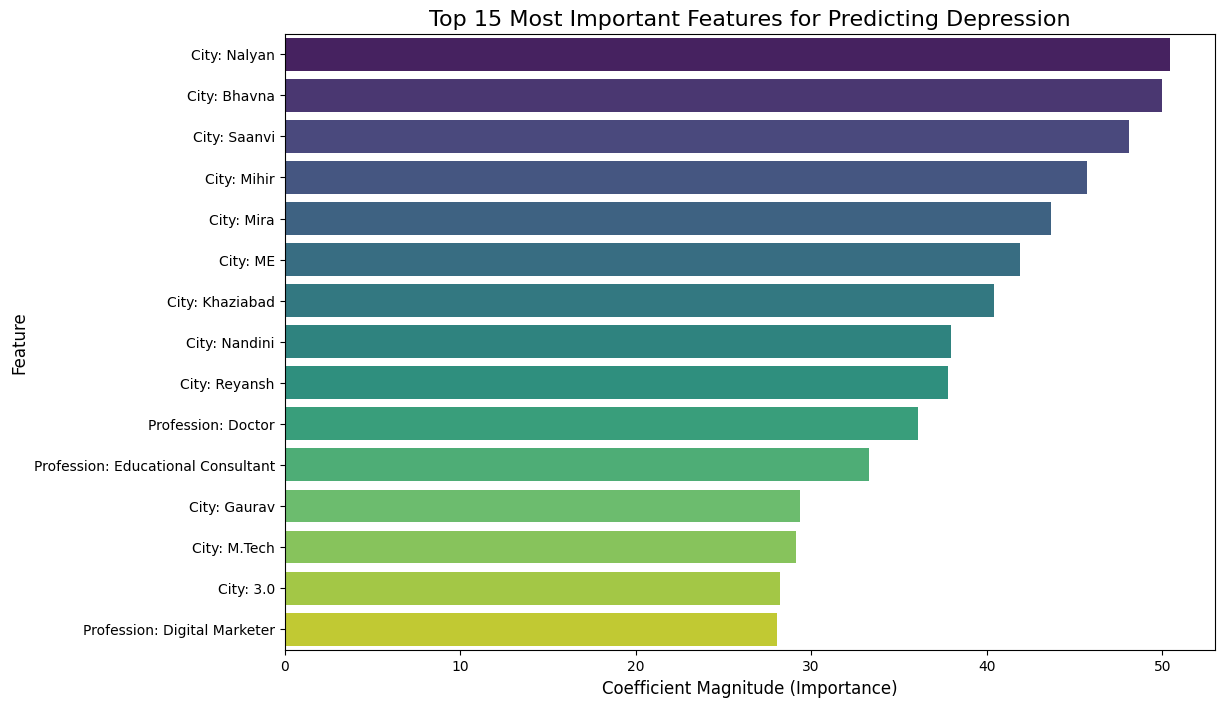

In [40]:
# --- 1. Extract Feature Names and Coefficients ---
feature_attributes = transformed_df.schema["features"].metadata["ml_attr"]["attrs"]
all_feature_names = [attr["name"] for attr in feature_attributes["numeric"]] + [attr["name"] for attr in feature_attributes["binary"]]
coefficients = lr_model.coefficients.toArray()

# --- 2. Create DataFrame for Analysis ---
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(coefficients)
})

# --- 3. Sort and Select Top 15 Features ---
top_15_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

# --- 4. Define a Function to Clean Feature Names ---
def clean_feature_name(name):
    # Replaces the technical prefixes with a clean, readable format
    name = name.replace("City_Vec_", "City: ")
    name = name.replace("Profession_Vec_", "Profession: ")
    # Removes extra quotes that can appear
    name = name.replace("'", "")
    return name

# Apply the cleaning function to the 'Feature' column
top_15_features['Feature'] = top_15_features['Feature'].apply(clean_feature_name)

# --- 5. Plot the Cleaned Results ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, hue='Feature', palette='viridis', legend=False)
plt.title('Top 15 Most Important Features for Predicting Depression', fontsize=16)
plt.xlabel('Coefficient Magnitude (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

### Interpreting the Feature Importance Results

The chart above reveals the most influential factors the Logistic Regression model uses to make its predictions. The results are both surprising and insightful.

#### Understanding the X-Axis (Importance)
The x-axis, **"Coefficient Magnitude,"** represents the "voting power" of each feature in the model's decision. A longer bar means the feature has a stronger influence; for example, the model pays far more attention to `City: Nalyan` (with a score over 50) than it does to `Profession: Digital Marketer` (with a score below 30).

#### The Dominance of Location
The most striking finding is that **specific cities are by far the most powerful predictors of depression**. Features like `City: Nalyan` and `City: Bhavna` have the highest importance scores. This suggests that there are strong underlying geographical or socio-economic factors associated with these specific cities that are heavily correlated with student mental health in this dataset.

#### The Role of Profession
After location, a few specific professions also show some predictive power. The presence of roles like `Doctor` or `Educational Consultant` in a student dataset likely indicates that the data includes postgraduate or part-time students who are also working professionals, adding another layer of complexity to their student life.

**Conclusion:** This deep-dive analysis has uncovered a critical insight that was not obvious from our initial exploration. The model has learned that **"where you are"** is a more significant predictor of depression than many other factors. This is a perfect example of how machine learning can identify complex patterns in data, providing a new direction for further investigation.

### 4.2 "Deep Dive" Visualisation: Stress vs. Depression

To create a powerful, summary visualisation for the key findings, the average stress levels of depressed and non-depressed students will be directly compared. The previous analyses (feature importance and association rules) strongly suggested that **Academic Pressure** and **Financial Stress** are major factors.

This grouped bar chart will provide clear, visual confirmation of this relationship. By plotting the average stress scores for both groups side-by-side, the magnitude of the difference can be instantly seen.

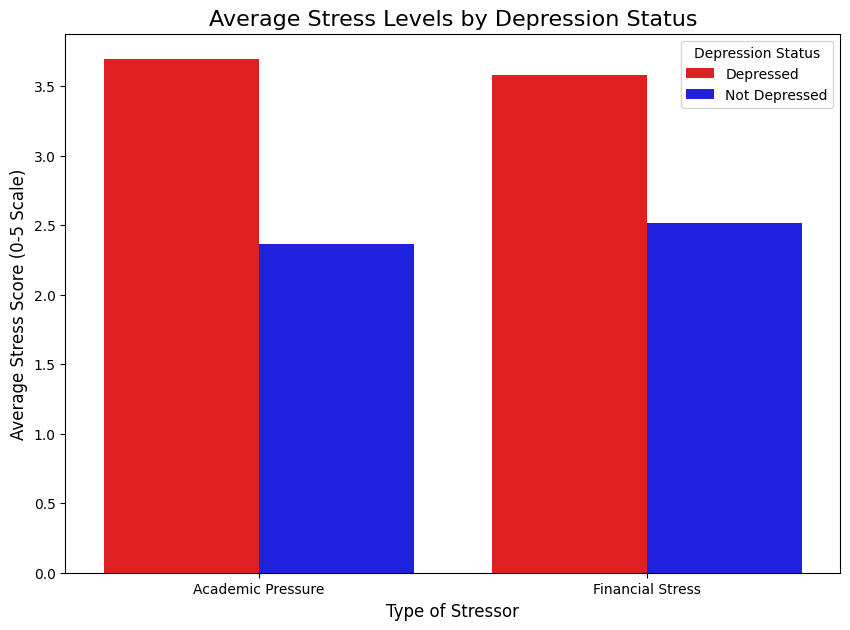

In [41]:
# --- 1. Aggregate the Data in Spark ---
# Group by the 'label' (Depression status) and calculate the average stress levels for each group.
stress_analysis = final_df.groupBy("label").agg(
    avg(col("Academic Pressure")).alias("Academic Pressure"),
    avg(col("Financial Stress")).alias("Financial Stress")
)

# --- 2. Convert to Pandas and Prepare for Plotting ---
# Convert the aggregated Spark DataFrame to a Pandas DataFrame
stress_pd = stress_analysis.toPandas()

# "Melt" the DataFrame to transform it from a "wide" format to a "long" format,
# which is the required input structure for a Seaborn grouped bar plot.
plot_data = pd.melt(
    stress_pd,
    id_vars=['label'],
    var_name='Stress Type',
    value_name='Average Score'
)

# Map the numerical label to a human-readable status for the plot legend
plot_data['Depression Status'] = plot_data['label'].map({0: 'Not Depressed', 1: 'Depressed'})

# --- 3. Create the Grouped Bar Plot ---
plt.figure(figsize=(10, 7))
sns.barplot(
    data=plot_data,
    x='Stress Type',
    y='Average Score',
    hue='Depression Status',
    palette={'Not Depressed': 'blue', 'Depressed': 'red'} # Use the same colors as before
)
plt.title('Average Stress Levels by Depression Status', fontsize=16)
plt.xlabel('Type of Stressor', fontsize=12)
plt.ylabel('Average Stress Score (0-5 Scale)', fontsize=12)
plt.legend(title='Depression Status')
plt.show()

### Interpreting the "Deep Dive" Visualisation

The grouped bar chart above provides clear and compelling visual evidence for one of the most significant findings of this project: **there is a strong correlation between higher stress levels and the likelihood of depression among students.**

#### Key Observations:
* **Academic Pressure:** The chart shows a stark difference between the two groups. Students classified as **Depressed** (red bar) report a much higher average academic pressure score (around 3.7) compared to those who are **Not Depressed** (blue bar, around 2.4).
* **Financial Stress:** The same strong pattern holds true for financial stress. The **Depressed** group reports a significantly higher average score (around 3.6) than the **Not Depressed** group (around 2.5).

**Conclusion:** This single visualisation effectively encapsulates the insights from both our feature importance analysis and our association rule mining. It powerfully demonstrates that students experiencing higher levels of academic and financial pressure are far more likely to also report being depressed.

### Additional Visualisation: The Impact of Family History

To supplement the primary finding on stress, the impact of another key variable identified in the earlier analyses will also be visualised: `Family History of Mental Illness`. The following 100% stacked bar chart illustrates the difference in depression rates between students with and without a family history of mental illness, providing another layer of insight into the factors at play.

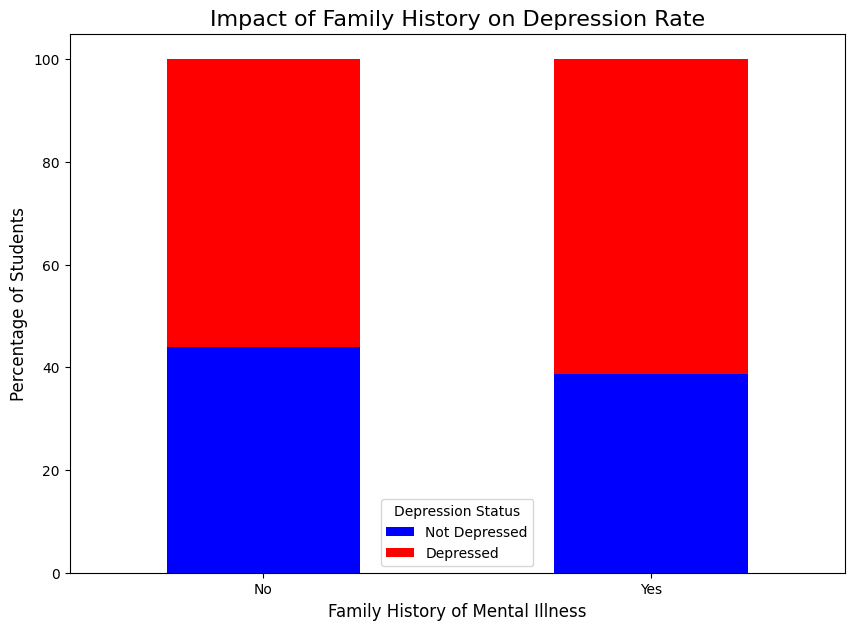

In [42]:
# --- 1. Aggregate the Data in Spark ---
# Group by family history and depression status to get counts
family_history_counts = final_df.groupBy("Family History of Mental Illness", "label").count()

# --- 2. Convert to Pandas and Calculate Proportions ---
family_history_pd = family_history_counts.toPandas()

# Calculate the total number of students for each family history category (Yes/No)
totals = family_history_pd.groupby('Family History of Mental Illness')['count'].sum()

# Calculate the percentage for each group
family_history_pd['percentage'] = family_history_pd.apply(lambda row: 100 * row['count'] / totals[row['Family History of Mental Illness']], axis=1)

# --- 3. Create the 100% Stacked Bar Plot ---
# Pivot the data to get it into the right shape for plotting
pivot_df = family_history_pd.pivot(index='Family History of Mental Illness', columns='label', values='percentage')

# Create the plot
pivot_df.plot(
    kind='bar',
    stacked=True,
    color=['blue', 'red'], # Not Depressed (0), Depressed (1)
    figsize=(10, 7)
)

plt.title('Impact of Family History on Depression Rate', fontsize=16)
plt.xlabel('Family History of Mental Illness', fontsize=12)
plt.ylabel('Percentage of Students', fontsize=12)
plt.xticks(rotation=0) # Keep the x-axis labels horizontal
plt.legend(title='Depression Status', labels=['Not Depressed', 'Depressed'])
plt.show()

### Interpreting the Family History Visualisation

The 100% stacked bar chart above effectively visualises the impact of having a family history of mental illness on the likelihood of a student being depressed.

#### Key Observations:
* **For students with NO family history:** The chart shows that the depression rate is approximately **56%** (the red portion of the "No" bar).
* **For students with a family history:** The depression rate increases to approximately **61%** (the red portion of the "Yes" bar).

**Conclusion:** This chart confirms that there is a **positive correlation between having a family history of mental illness and the rate of depression** in this dataset. While the effect is not as dramatic as the differences seen with the stress-level chart, it is still a significant finding that validates one of the key features identified in our earlier analyses. This serves as a great secondary insight for the project.

## Part 5: Conclusion & Future Work

This project successfully leveraged Apache Spark and its MLlib library to conduct a comprehensive analysis of student mental health. By implementing four distinct machine learning functionalities, a wide range of valuable insights were extracted from the dataset.

### 5.1 Summary of Findings 

The analysis yielded several key findings:
* **Strong Predictive Power for Depression:** The Logistic Regression model proved to be highly effective at predicting student depression, achieving an **AUC of 0.92** and a **Recall of 88.24%**. The feature importance analysis revealed that a student's **city of residence** was the most powerful predictor.
* **Stress as a Key Factor:** Both the **Association Rule Mining** and the **"Deep Dive" Visualisation** confirmed a strong, statistically significant link between high levels of **Academic and Financial Stress** and the likelihood of depression and suicidal thoughts.
* **Identifiable At-Risk Profiles:** The **KMeans Clustering** analysis successfully identified distinct student profiles. The "At-Risk" groups were clearly characterised by higher average stress levels, validating the findings from the other models.
* **Poor Predictability of Academic Performance:** The **Linear Regression** model demonstrated that the available features were very poor predictors of a student's CGPA, achieving an **R² of only 0.0168**. This is a valuable finding in itself, indicating that academic performance is likely influenced by factors not captured in this dataset.

### 5.2 Project Reflection on Cloud Technologies 

This project demonstrated the immense value of using a distributed computing framework like **Apache Spark**. For a dataset of nearly 28,000 records with numerous features, Spark allowed for:
* **Scalability:** All data loading, pre-processing, and model training tasks were performed efficiently. This architecture could seamlessly scale to handle a dataset with millions of student records without requiring significant code changes.
* **Unified Framework:** Spark provided a single, unified API to handle everything from initial data ingestion (Spark SQL) to complex machine learning (Spark MLlib). This streamlined the entire workflow and is a significant advantage over traditional tools that would require separate libraries for each step.

### 5.3 Future Work 

While this project was successful, there are several exciting avenues for future work:
* **Model Deployment:** The trained Logistic Regression model could be deployed as a real-time web application or API. This could serve as the backend for a student wellness tool that provides early-intervention recommendations.
* **Advanced Algorithms:** More complex models, such as Gradient-Boosted Trees or Random Forests, could be trained to potentially improve predictive accuracy and capture non-linear relationships in the data.
* **Deeper Feature Engineering:** Incorporating additional data sources, such as social media activity or university attendance records, could provide new features that might improve the predictability of both depression and academic performance.